In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Harris Corner Detection -- Manually Computed

![title](harris.jpg)

## Defining Sobel and Gaussian Kernel

In [7]:
#Defining Sobel Kernels X-axis
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")


 ## Implementing convolution function from scratch manually with zero padding

In [8]:
def convolve(img, kernel):
    #zero padding
    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

## Harris Corner Detection Steps performed in function harris_detect()

In [9]:
def harris_detect(img, threshold, k=0.12):
    # copying image
    img_copy1 = img.copy() 
    img_copy2 = img.copy()
    
    #Steps:
    print('Step-Wise Output')
    print('Input Image: \n', img, '\n')
    
    # convolving with sobel filter on X-axis
    dx = convolve(img_copy1, SOBEL_X) 
    print('----------X-axis derivative:-------------')
    print(dx, '\n', '\n')
    
    # convolving with sobel filter on Y-axis
    dy = convolve(img_copy1, SOBEL_Y) 
    print('----------Y-axis derivative:-------------')
    print(dy, '\n', '\n')
    
    # Computing square of derivatives
    dx2 = np.square(dx)
    print('----------Square of dx-------------')
    print(dx2, '\n', '\n')   
    
    dy2 = np.square(dy)
    print('----------Square of dy-------------')
    print(dy2, '\n', '\n')
    
    #Apply cross multiplication to get diagonal changes
    print('----------Diagonal Changes: dx*dy-------------')
    dxdy = dx*dy 
    print(dxdy, '\n', '\n')
    
    # Applying gaussian filter to all the directional changes: x, y, diagonal axis
    print('----------Gaussian Filter Outputs on three derivatives-------------')
    g_dx2 = convolve(dx2, GAUSS)
    
    print('Gaussian on dx^2')
    print(g_dx2,  '\n', '\n')
    
    g_dy2 = convolve(dy2, GAUSS)
    print('Gaussian on dy^2')
    print(g_dy2, '\n', '\n')
    
    g_dxdy = convolve(dxdy, GAUSS)
    print('Gaussian on dx*dy')
    print(g_dx2, '\n', '\n')
    
    # Apply cornerness function or harris function
    # r(harris) = det - k*(trace**2)
    print('----------Harris Cornerness Function: = det - k*(trace**2)-------------')
    harris = g_dx2*g_dy2 - np.square(g_dxdy) - k*np.square(g_dx2 + g_dy2) 
    print(harris, '\n', '\n')
    
    # Normalizing between (0 to 1)
    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)

    # apply non-maxima supression and find all points above threshold
    print('---------Thresholding-------------')
    loc = np.where(harris >= threshold)
    print('Corner Pixel Locations: ', loc  )
    return loc

# Image Reading and Filtering Area

[[ 18  18  19  21  20]
 [ 18  24  16  22  21]
 [ 17  15  26  21  21]
 [ 20  18  26 203 200]
 [ 22  23  20 212 209]]


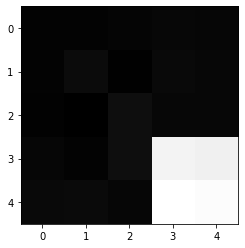

In [12]:

#Already a grayscale image
img = mpimg.imread('image_patch/c4.jpg')
print(img)
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)


# Outputs: Step-Wise

In [13]:
loc = harris_detect(img, 0.85)
print(loc)

Step-Wise Output
Input Image: 
 [[ 18  18  19  21  20]
 [ 18  24  16  22  21]
 [ 17  15  26  21  21]
 [ 20  18  26 203 200]
 [ 22  23  20 212 209]] 

----------X-axis derivative:-------------
[[  60.    0.    4.    7.  -64.]
 [  81.    6.    5.    6.  -86.]
 [  72.   22.  195.  169. -267.]
 [  74.   19.  565.  532. -639.]
 [  64.    2.  563.  552. -627.]] 
 

----------Y-axis derivative:-------------
[[  60.   82.   78.   81.   64.]
 [  -5.    0.   11.    8.    2.]
 [  -2.    0.  195.  551.  539.]
 [  18.   15.  187.  564.  567.]
 [ -58.  -82. -273. -632. -603.]] 
 

----------Square of dx-------------
[[3.60000e+03 0.00000e+00 1.60000e+01 4.90000e+01 4.09600e+03]
 [6.56100e+03 3.60000e+01 2.50000e+01 3.60000e+01 7.39600e+03]
 [5.18400e+03 4.84000e+02 3.80250e+04 2.85610e+04 7.12890e+04]
 [5.47600e+03 3.61000e+02 3.19225e+05 2.83024e+05 4.08321e+05]
 [4.09600e+03 4.00000e+00 3.16969e+05 3.04704e+05 3.93129e+05]] 
 

----------Square of dy-------------
[[3.60000e+03 6.72400e+03 6.08400e

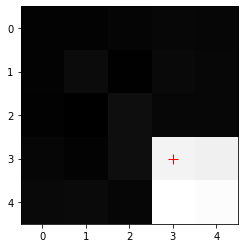

In [14]:
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(loc[1], loc[0], color='red', marker='+',
        linestyle='None', markersize=10)
plt.show()